<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/BERT_All_Lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install -U sentence-transformers --quiet

In [87]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
root = '/content/drive/MyDrive/ANLP21/'
out = root+"out/"

In [89]:
import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

nlp = spacy.load("en_core_web_sm")
df = pd.read_csv(root+"concatenated-all-characters.csv")

# df['item'] = df.apply(lambda row: row['item'].split('{} says, "'.format(row['character']))[1][:-1], axis =1)
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,film,scene,item_ids,item,character,protagonist,xAttr,MotivatedByGoal,xReact
0,10,705912,705912,10_things_i_hate_about_you.txt,1,11,"RIDER says, ""Hey -- sorry.""",RIDER,KAT,"[' apologetic', ' remorseful', ' sorry', ' sor...","[' ', ' sorry', ' they are sorry', ' none...","[' sorry', ' relieved', ' sad', ' good', ' hap..."
1,12,705914,705914,10_things_i_hate_about_you.txt,1,13,"KAT says, ""Leave it""",KAT,KAT,"[' independent', ' decisive', ' mean', ' deter...","[' KAT LEAVES IT.', ' KAT LEAVES IT', ' KAT LE...","[' good.', ' satisfied', ' relieved', ' happy'..."
2,18,705920,705920,10_things_i_hate_about_you.txt,2,3,"BIANCA says, ""Did you change your hair?""",BIANCA,KAT,"[' curious', ' fashionable', ' confident', ' m...","[' PersonY looks at PersonY', ' PersonX looks ...","[' happy.', ' happy', ' curious', ' satisfied'..."
3,19,705921,705921,10_things_i_hate_about_you.txt,2,4,"CHASTITY says, ""No.""",CHASTITY,KAT,"[' decisive', ' determined', ' independent', '...","[' CHASTITY DOES NOT KNOW', ' ', ' CHASTITY'...","[' good.', ' satisfied', ' happy', ' good', ' ..."
4,20,705922,705922,10_things_i_hate_about_you.txt,2,5,"BIANCA says, ""You might wanna think about it""",BIANCA,KAT,"[' considerate', ' thoughtful', ' curious', ' ...","[' PersonY listens to PersonY', ' PersonY thin...","[' good.', ' good', ' informed', ' happy', ' s..."


In [90]:
cf = pd.read_csv(root+'characters-test-train-dev.csv')
# cf['film'] = cf['film'].apply(lambda film: film.replace(".txt.txt.txt.txt.txt.txt.txt",".txt"))

cf1 = cf[cf.apply(lambda row: row['set'] in ['train'], axis=1)] 
train_characters = cf1[['film','character']]

cf2 = cf[cf.apply(lambda row: row['set'] in ['dev'], axis=1)] 
dev_characters = cf2[['film','character']]

print(len(train_characters), len(dev_characters))
train_characters

184 40


,film,character
0,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM
1,the_family_man.txt,JACK
2,platoon.txt,BARNES
3,jane_eyre.txt,JANE
4,sling_blade.txt,KARL
...,...,...
179,the_sixth_sense.txt,COLE
180,schindlers_list.txt,SCHINDLER
181,pulp_fiction.txt,VINCENT
182,jurassic_park_2_the_lost_world.txt,MALCOLM


In [91]:
df_train =  pd.merge(train_characters, df, on=["film", "character"], how='inner')
df_dev =  pd.merge(dev_characters, df, on=["film", "character"], how='inner')

In [92]:
import numpy as np



In [93]:
film_char_group = df_train.groupby(['film','character'])

df_film_char_embed = []
for film_char, group in film_char_group:
  df_film_char_embed.append({'film':film_char[0], 'character':film_char[1], 'embedding': sentence_model.encode(group['item'].str.cat(sep=' '))})

df_film_char_embed = pd.DataFrame(df_film_char_embed)
df_film_char_embed

,film,character,embedding
0,2001_a_space_odyssey.txt,HAL,"[-0.011546325, -0.003194049, 0.018663133, -0.0..."
1,a_nightmare_on_elm_street.txt,NANCY,"[0.015839169, -0.008331945, 0.015410923, -0.01..."
2,airplane.txt,ELAINE,"[0.0057449904, -0.029634021, -0.0043145074, -0..."
3,airplane_ii_the_sequel.txt,TED,"[-0.046830747, -0.0311474, 0.0011543029, -0.01..."
4,aliens.txt,RIPLEY,"[-0.02288213, -0.0076642884, 0.00019169987, -0..."
...,...,...,...
173,what_lies_beneath.txt,CLAIRE,"[0.0023780419, 0.004354018, -0.022028442, -0.0..."
174,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM,"[0.0032251133, -0.0006000645, 0.017893964, -0...."
175,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,JESSICA RABBIT,"[0.00828464, 0.016007207, -0.01741103, -0.0266..."
176,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,ROGER RABBIT,"[-0.010705145, 0.022621064, -0.031093411, -0.0..."


In [94]:
df_film_char_embed

,film,character,embedding
0,2001_a_space_odyssey.txt,HAL,"[-0.011546325, -0.003194049, 0.018663133, -0.0..."
1,a_nightmare_on_elm_street.txt,NANCY,"[0.015839169, -0.008331945, 0.015410923, -0.01..."
2,airplane.txt,ELAINE,"[0.0057449904, -0.029634021, -0.0043145074, -0..."
3,airplane_ii_the_sequel.txt,TED,"[-0.046830747, -0.0311474, 0.0011543029, -0.01..."
4,aliens.txt,RIPLEY,"[-0.02288213, -0.0076642884, 0.00019169987, -0..."
...,...,...,...
173,what_lies_beneath.txt,CLAIRE,"[0.0023780419, 0.004354018, -0.022028442, -0.0..."
174,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM,"[0.0032251133, -0.0006000645, 0.017893964, -0...."
175,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,JESSICA RABBIT,"[0.00828464, 0.016007207, -0.01741103, -0.0266..."
176,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,ROGER RABBIT,"[-0.010705145, 0.022621064, -0.031093411, -0.0..."


In [95]:
temp_list = df_film_char_embed.to_records(index=False)
embed_list = [t[2] for t in temp_list]
film_char_list = ["{film}_{char}".format(film = t[0], char = t[1]) for t in temp_list]
X = np.array(embed_list)
w = len(df_film_char_embed)
h = 1
d = 768
Y = np.zeros(w)

In [96]:
def plot_3d(X, w, h, d, Y):
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, c=Y, cmap='viridis')


def plot_2d(X, w, h, d, Y):
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, c=Y, cmap='viridis')

In [97]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs

# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
def elbow(X, w, h, d, method, k_range):
      X = X.reshape((w,h*d))
      model = KMeans()
      visualizer = KElbowVisualizer(model, k=k_range)
      visualizer.fit(X)        
      visualizer.show() 

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette(X, w, h, d, method, k):
      X = X.reshape((w,h*d))
      model = KMeans(k, random_state=42)
      visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
      visualizer.fit(X)        # Fit the data to the visualizer
      visualizer.show() 



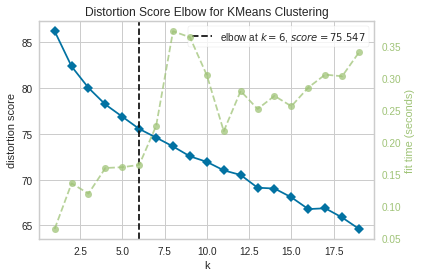

In [98]:
elbow(X, w, h, d, "BERT", (1,20))

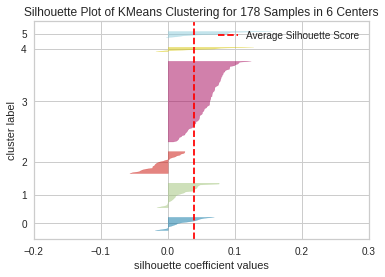

In [99]:
silhouette(X, w, h, d, "BERT", 6)

In [100]:
df_film_char_embed

,film,character,embedding
0,2001_a_space_odyssey.txt,HAL,"[-0.011546325, -0.003194049, 0.018663133, -0.0..."
1,a_nightmare_on_elm_street.txt,NANCY,"[0.015839169, -0.008331945, 0.015410923, -0.01..."
2,airplane.txt,ELAINE,"[0.0057449904, -0.029634021, -0.0043145074, -0..."
3,airplane_ii_the_sequel.txt,TED,"[-0.046830747, -0.0311474, 0.0011543029, -0.01..."
4,aliens.txt,RIPLEY,"[-0.02288213, -0.0076642884, 0.00019169987, -0..."
...,...,...,...
173,what_lies_beneath.txt,CLAIRE,"[0.0023780419, 0.004354018, -0.022028442, -0.0..."
174,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM,"[0.0032251133, -0.0006000645, 0.017893964, -0...."
175,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,JESSICA RABBIT,"[0.00828464, 0.016007207, -0.01741103, -0.0266..."
176,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,ROGER RABBIT,"[-0.010705145, 0.022621064, -0.031093411, -0.0..."


In [101]:
kmeans = KMeans(n_clusters= 6)
label = kmeans.fit_predict(X.reshape((w,h*d)))

In [102]:
def get_cluster(row, label):
  film = row['film']
  char = row['character']
  film_char ="{film}_{char}".format(film = film, char = char)
  if film_char in film_char_list:
    return label[film_char_list.index(film_char)]
  else:
    return None

df_film_char_embed['cluster'] = df_film_char_embed.apply(lambda row: get_cluster(row, label), axis = 1)
df1 = df_film_char_embed[['film','character','cluster']]
df1 = df1.drop_duplicates()

df1.to_csv('/content/drive/MyDrive/ANLP21/out/bert_train.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


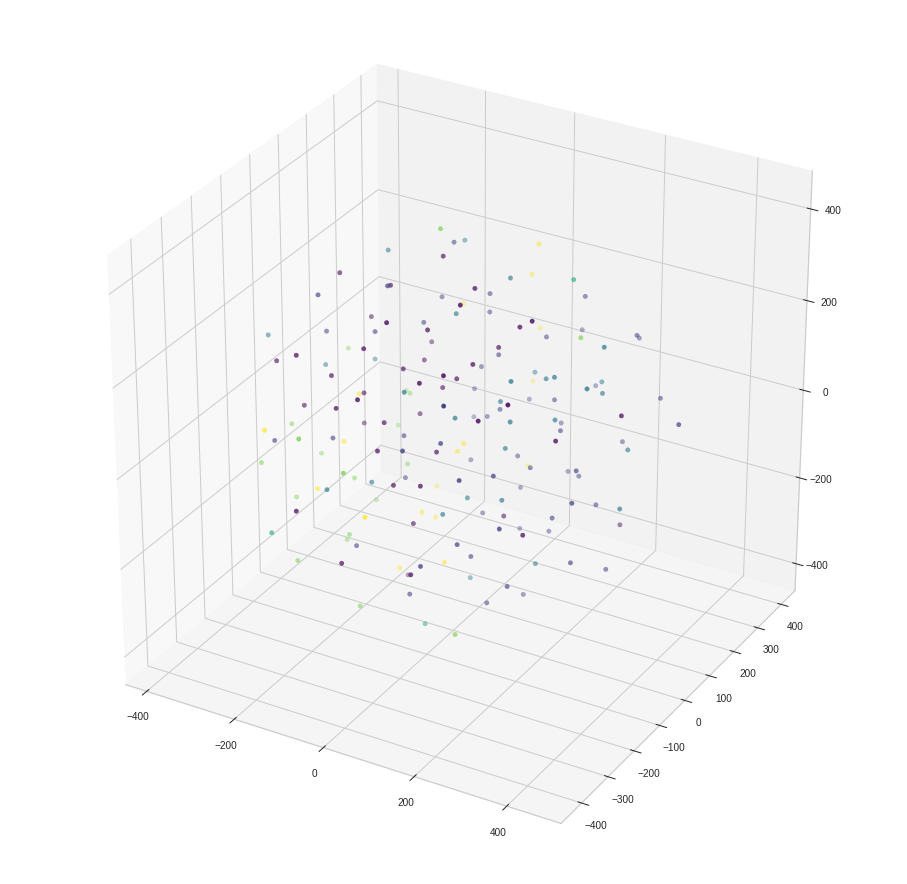

In [103]:
plot_3d(X, w, h, d, label)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


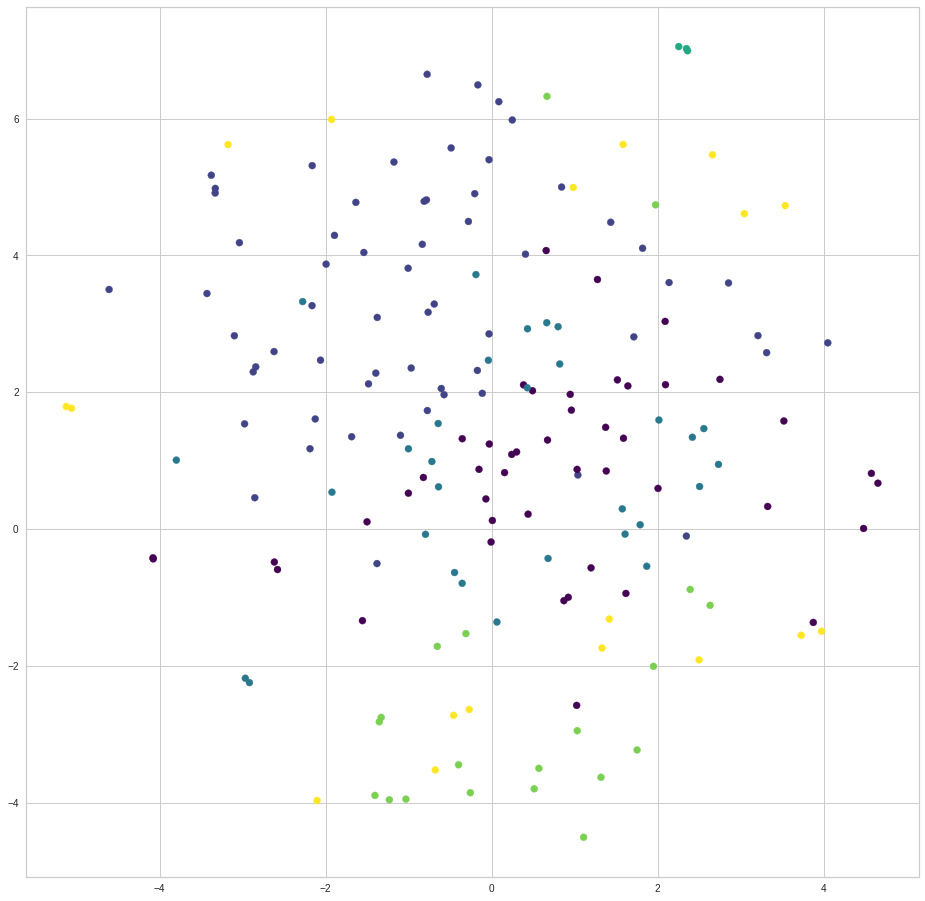

In [105]:
plot_2d(X, w, h, d, label)